# Compute Magnitudes from Pickle SED in Auxtel filters (SDSS prime)

- author Sylvie Dagoret-Campagne
- creation date : 2024/07/29

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

In [3]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Your current machine name is iMac-de-Sylvie.local. Check your python environment


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [5]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("AUXTEL")

AUXTEL site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

#### Library to fit atmosphere

In [7]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

#### Library that encapsulate calculations for Photometric correction

In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [9]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [10]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

#### library rubin_sim defining LSST parameters, namely for photometric calculations

In [11]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

## Configuration

In [12]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [13]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/AtmosphericTransmission/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

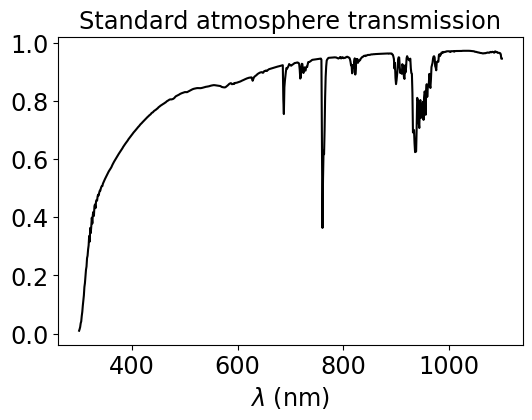

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check LSST instrument throughput

Photometric Correction package should find the instrumental passband of LSST

Text(0.5, 1.0, 'Instrument throughput (auxtel)')

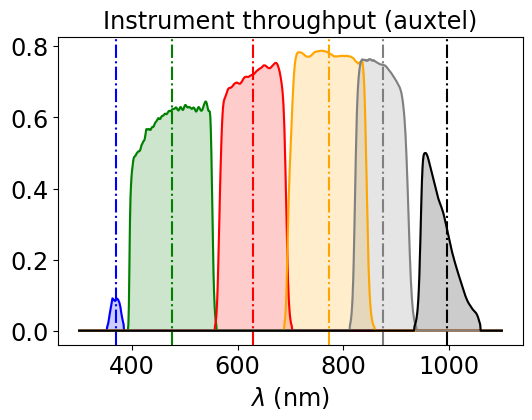

In [15]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (auxtel)")

### Check LSST standard Filter throughputs

Text(0.5, 1.0, 'Total filter throughput (auxtel)')

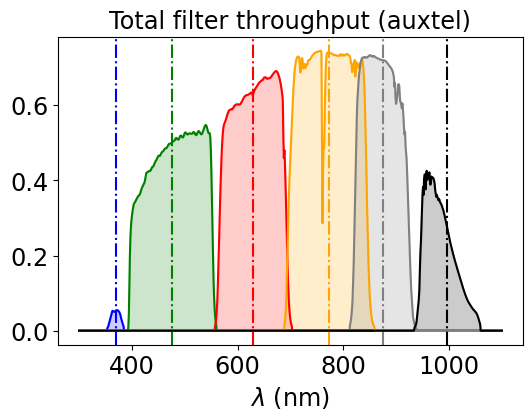

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (auxtel)")

## Variation of PWV

In [17]:
am = 1.2
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,10,0.5)
NPWV = len(all_pwv)

In [18]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

### PWV variation :  Observed filter and normalized response

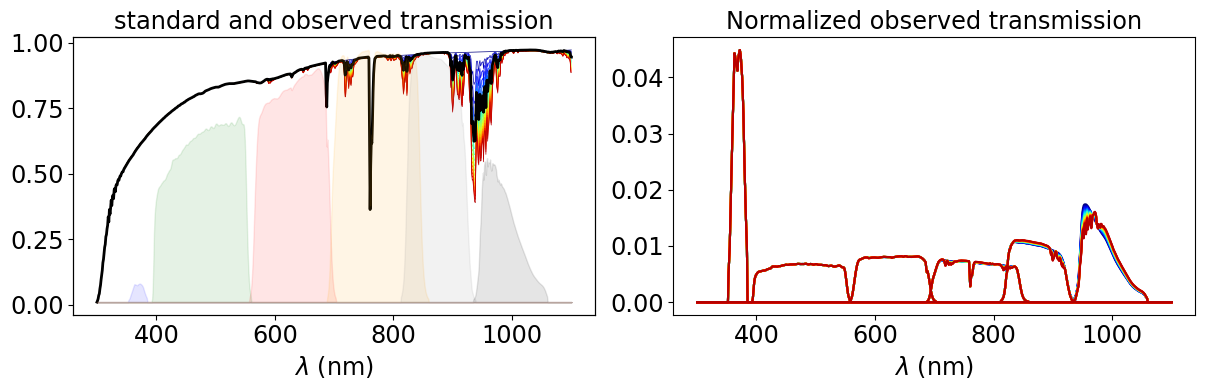

In [19]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    
    label = f"pwv={pwv:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



## SED

In [20]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

In [21]:
seddir = os.path.join(fdir, 'pysynphot', 'pickles')

In [22]:
seddir_uvi = os.path.join(seddir,"dat_uvi")
seddir_uvk = os.path.join(seddir,"dat_uvk")

In [23]:
all_pickles_uvi = sorted(os.listdir(seddir_uvi))
all_pickles_uvk = sorted(os.listdir(seddir_uvk))

In [24]:
file_ref = os.path.join(seddir_uvk, "pickles_uk.fits")

In [25]:
hdul = fits.open(file_ref)

In [26]:
df_pickle = pd.DataFrame(hdul[1].data)

In [27]:
df_pickle

,FILENAME,SPTYPE
0,pickles_uk_1,O5V
1,pickles_uk_2,O9V
2,pickles_uk_3,B0V
3,pickles_uk_4,B1V
4,pickles_uk_5,B3V
...,...,...
126,pickles_uk_127,G8I
127,pickles_uk_128,K2I
128,pickles_uk_129,K3I
129,pickles_uk_130,K4I


In [28]:
NSED = len(df_pickle)

In [29]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

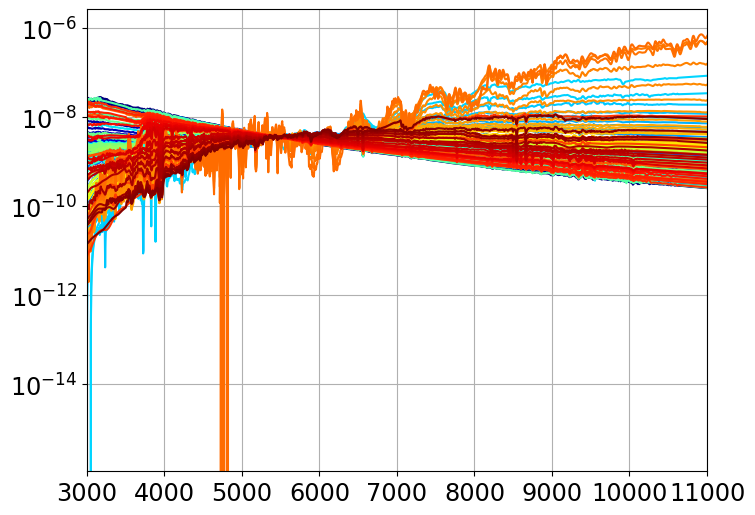

In [32]:
for index in np.arange(NSED):
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    plt.plot(dff.WAVELENGTH,dff.FLUX,color=all_colors[index])
plt.yscale('log')
plt.xlim(3000.,11000)
plt.grid()
    

## Convert SED in rubinsim format

In [37]:
all_sed = []
zmag = 20.0
for index in np.arange(NSED):
    spectype = df_pickle.loc[index,"SPTYPE"].strip()
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    wl= dff.WAVELENGTH.values
    flux = dff.FLUX.values
    #wavelen (nm)
    #flambda (ergs/cm^2/s/nm)
    the_sed = Sed(wavelen=wl/10., flambda=flux*10., name=spectype)
    flux_norm = the_sed.calc_flux_norm(zmag, pc.bandpass_total_std['z'])
    the_sed.multiply_flux_norm(flux_norm)
    all_sed.append(the_sed) 

### Check the calculation of the Magnitude and the ADC counts (observation)

In [42]:
the_sed = all_sed[0]

In [43]:
mags_std = {}
for index,f in enumerate(filter_tagnames) :
    mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
    
pd.DataFrame(mags_std, index=[the_sed.name]).T

,O5V
u,18.312840
g,18.755737
r,19.353637
i,19.754387
z,20.000000
y,20.202393


In [45]:
photoparams = set_photometric_parameters(30, 1 , readnoise=None)
adcs_std = {}
for index,f in enumerate(filter_tagnames) :
    adcs_std[f] = the_sed.calc_adu(pc.bandpass_total_std[f],photoparams)
    
pd.DataFrame(adcs_std, index=[the_sed.name]).T

,O5V
u,3603.264075
g,113188.667260
r,53149.913149
i,39604.231177
z,18608.867736
y,5228.740676
